In [1]:
import os
import pickle
import cv2
import h5py

import torch
from torchvision import transforms
import numpy as np
from pathlib import Path

from models import _get_model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt


## Load Data

In [2]:
data_path = './sample_data/'

data_list = ['20201111.140224.127.P20-12995-002Stitching', '20201120.132117.523.P20-12523_1-005Stitching',
             '20201130.130437.996.P20-11900-007Stitching', '20201211.140034.973.P20-18313_2-005Stitching',
             '20201211.145526.231.P20-17419-003Stitching', '20201214.105659.251.P20-17177-003', '20201217.131555.276.P20-15999_2-008Stitching']


color_clst = np.load(os.path.join(data_path, data_list[1], 'color.npy'))
ri_clst = np.load(os.path.join(data_path, data_list[1], 'ri.npy'))
label = np.load(os.path.join(data_path, data_list[1], 'label.npy'))

print(color_clst.shape, ri_clst.shape, label)

(3, 675, 677) (675, 677) 1


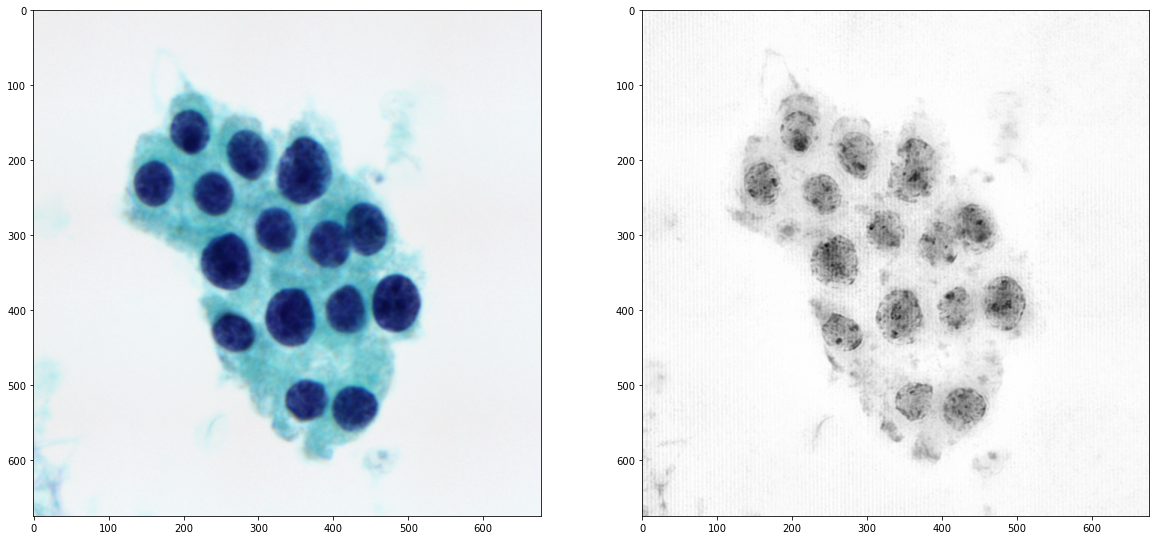

In [3]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(color_clst.astype(np.uint8).transpose(1,2,0))
plt.subplot(122)
plt.imshow(ri_clst, cmap='gray_r')
plt.show()

## Feature Extraction

In [4]:
color_model = _get_model(name='densenet169', model_type='nbs', num_classes=1, in_channels=3)
ri_model = _get_model(name='densenet169', model_type='nbs', num_classes=1, in_channels=1)

color_state_dict = torch.load("./patch_models/color_model.pth", map_location='cpu')
ri_state_dict = torch.load('./patch_models/ri_model.pth', map_location='cpu')

color_model.load_state_dict(color_state_dict)
ri_model.load_state_dict(ri_state_dict)

color_model.eval()
ri_model.eval()

ConvNet(
  (backbone): BackboneGetter(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [8]:
class SampleDataset(torch.utils.data.Dataset):

    def __init__(self, color_clst, ri_clst, label, color_transform, ri_transform):
        self.color_clst = color_clst
        self.ri_clst = ri_clst
        self.label = label
        self.color_transform = color_transform
        self.ri_transform = ri_transform

        self._patching()

    def __len__(self):
        return len(self.color_patches)
    
    def __getitem__(self, idx):
        color_patch = self.color_patches[idx]
        ri_patch = self.ri_patches[idx]
        coord = self.coords[idx]

        color_patch = self.color_transform(np.uint8(color_patch.transpose(1,2,0)))
        ri_patch = self.ri_transform(np.uint8(ri_patch))

        return color_patch, ri_patch, coord, label
    
    def _patching(self, ):
        stride, patch_size = 128, 256

        h, w = self.color_clst.shape[1:]

        h_ = h // stride - patch_size // stride + 1
        w_ = w // stride - patch_size // stride + 1

        self.color_patches = []
        self.ri_patches = []
        self.coords = []

        for i in range(h_):
            for j in range(w_):

                color_patch = self.color_clst[:, i*stride: i*stride+patch_size, j*stride: j*stride+patch_size]
                ri_patch = self.ri_clst[i*stride: i*stride+patch_size, j*stride: j*stride+patch_size]
                color_hsv = cv2.cvtColor(color_patch.transpose(2,1,0), cv2.COLOR_RGB2HSV)
                sat = color_hsv[:, :, 1] * 255

                if np.mean(color_patch) < 170 and np.min(color_patch) > 1 and np.mean(sat) > 30:
                    self.color_patches.append(color_patch)
                    self.ri_patches.append(ri_patch)
                    self.coords.append([i, j])

In [9]:
color_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

ri_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.445, 0.269)
])

dataset = SampleDataset(color_clst, ri_clst, label, color_transform, ri_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [10]:
color_results = []
ri_results = []

for batch in data_loader:
    color_patch, ri_patch, coords, labels = batch
    color_patch = color_patch
    ri_patch = ri_patch
    color_pred = color_model(color_patch, 5)
    color_pred = color_pred.sigmoid()
    ri_pred = ri_model(ri_patch, 5)
    ri_pred = ri_pred.sigmoid()


for i in range(len(dataset)):
    color_prob = color_pred[:, i, :].mean(0).detach().numpy()
    ri_prob = ri_pred[:, i, :].mean(0).detach().numpy()
    coord_h, coord_w = coords[0][i].detach().numpy(), coords[1][i].detach().numpy()
    label = labels[i].detach().numpy()

    color_results.append([color_prob, coord_h, coord_w, label])
    ri_results.append([ri_prob, coord_h, coord_w, label])

In [11]:
def compute_heatmap(h, w, items):
    patch_size = 256
    stride = 128
    
    heatmap = np.zeros((h, w), dtype=np.float32)

    for p in range(len(items)):
        print(items[p][1], items[p][2])
        x1, y1 = items[p][1] * stride, items[p][2] * stride
        x2, y2 = x1 + patch_size, y1 + patch_size

        heatmap_patch = heatmap[x1:x2, y1:y2]
        probs = items[p][0]
        patch = np.ones((patch_size, patch_size), dtype=np.float32) * probs

        nones = heatmap_patch == 0
        heatmap_patch[nones] += patch[nones]

        heatmap_patch[~nones] = np.mean(np.array([heatmap_patch[~nones], patch[~nones]]), axis=(0,1))
    
        heatmap[x1:x2, y1:y2] = heatmap_patch
     
    return heatmap

def compute_cluster_feature(heatmap, ratio=0.5):

    clst_x, clst_y = heatmap.shape
    clst_x_center = clst_x // 2
    clst_y_center = clst_y // 2

    region_x = int(clst_x * ratio)
    region_y = int(clst_y * ratio)

    clst_x_start, clst_y_start = clst_x_center - (region_x // 2), clst_y_center - (region_y // 2)
    clst_x_end, clst_y_end = clst_x_center + (region_x // 2), clst_y_center + (region_y // 2)

    clst_region = heatmap[clst_x_start:clst_x_end, clst_y_start:clst_y_end]
    return np.mean(clst_region)

In [12]:
def compute_patch_feature(heatmap, color_item, ri_item, ratio=0.5):

    clst_x, clst_y = heatmap.shape
    clst_x_center, clst_y_center = clst_x // 2, clst_y // 2

    region_x, region_y = int(clst_x * ratio), int(clst_y * ratio)

    clst_x_start, clst_y_start = clst_x_center - (region_x // 2), clst_y_center - (region_y // 2)
    clst_x_end, clst_y_end = clst_x_center + (region_x // 2), clst_y_center + (region_y // 2)

    patch_size = 256
    stride = 128

    patch_first_feature = []
    patch_second_feature = []
    patch_thrid_feature = []

    for i in range(len(color_item)):
        x_start, y_start = color_item[i][1] * stride, color_item[i][2] * stride
        x_end, y_end = x_start + patch_size, y_start + patch_size

        if x_end < clst_x_start and x_start > clst_x_end and y_end < clst_y_start and y_start > clst_y_end:
            pass
        else:
            color_patch = int(color_item[i][0] > 0.5)
            ri_patch = int(ri_item[i][0] > 0.5)

            patch_first_feature.append(int(color_patch & ri_patch))
            patch_second_feature.append(int(color_patch | ri_patch))
            patch_thrid_feature.append(int(color_patch ^ ri_patch))

    return np.mean(patch_first_feature), np.mean(patch_second_feature), np.mean(patch_thrid_feature)

In [13]:
X_test = []
y_test = []

if len(color_results) < 5:
    print(f"{len(color_results)} patches are extracted")
else:
    
    color_heatmap = compute_heatmap(color_clst.shape[1], color_clst.shape[2], color_results)
    color_cluster_feature = compute_cluster_feature(color_heatmap, ratio=0.5)

    ri_heatmap = compute_heatmap(ri_clst.shape[0], ri_clst.shape[1], ri_results)
    ri_cluster_feature = compute_cluster_feature(ri_heatmap, ratio=0.5)

    and_feature, or_feature, xor_feature = compute_patch_feature(color_heatmap, color_results, ri_results, ratio=0.5)
    X_test.append([color_cluster_feature, ri_cluster_feature, and_feature, or_feature, xor_feature])

    y_test.append(color_results[0][3])

X_test = np.array(X_test)
y_test = np.array(y_test)

3 patches are extracted


## Cluster-prediction Model

### XGBoost

In [14]:
def get_label(num):
    return 'benign' if num == 0 else 'malignant' 

In [15]:
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42, max_depth=6, n_estimators=200)
xgb_model = pickle.load(open('./clst_models/cluster_xgboost.pkl', 'rb'))

In [44]:
xgb_pred = xgb_model.predict(X_test)
print(f'Model prediction - {get_label(xgb_pred.item())} / Ground truth - {get_label(y_test.item())}')

XGBoostError: [10:54:56] ../src/predictor/cpu_predictor.cc:258: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 5) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) /opt/conda/lib/libxgboost.so(+0x358248) [0x7f169e1ab248]
  [bt] (1) /opt/conda/lib/libxgboost.so(void xgboost::predictor::CPUPredictor::DispatchedInplacePredict<xgboost::data::ArrayAdapter>(dmlc::any const&, std::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const+0x237) [0x7f169e1b91e7]
  [bt] (2) /opt/conda/lib/libxgboost.so(xgboost::predictor::CPUPredictor::InplacePredict(dmlc::any const&, std::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const+0x3b0) [0x7f169e1ba940]
  [bt] (3) /opt/conda/lib/libxgboost.so(xgboost::gbm::GBTree::InplacePredict(dmlc::any const&, std::shared_ptr<xgboost::DMatrix>, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const+0x140) [0x7f169e1167c0]
  [bt] (4) /opt/conda/lib/libxgboost.so(xgboost::LearnerImpl::InplacePredict(dmlc::any const&, std::shared_ptr<xgboost::DMatrix>, xgboost::PredictionType, float, xgboost::HostDeviceVector<float>**, unsigned int, unsigned int)+0x1ff) [0x7f169e14270f]
  [bt] (5) /opt/conda/lib/libxgboost.so(void InplacePredictImpl<xgboost::data::ArrayAdapter>(std::shared_ptr<xgboost::data::ArrayAdapter>, std::shared_ptr<xgboost::DMatrix>, char const*, xgboost::Learner*, unsigned long, unsigned long, unsigned long const**, unsigned long*, float const**)+0x397) [0x7f169e033497]
  [bt] (6) /opt/conda/lib/libxgboost.so(XGBoosterPredictFromDense+0x28a) [0x7f169e01f0ba]
  [bt] (7) /opt/conda/lib/python3.8/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f199b45da4a]
  [bt] (8) /opt/conda/lib/python3.8/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f199b45cfea]



### Random Forest

In [27]:
rf_model = RandomForestClassifier(random_state=42, max_depth=6, n_estimators=200)
rf_model = pickle.load(open('./clst_models/cluster_rf.pkl', 'rb'))

In [28]:
rf_pred = rf_model.predict(X_test)
print(f'Model prediction - {get_label(rf_pred.item())} / Ground truth - {get_label(y_test.item())}')

Model prediction - benign / Ground truth - malignant


### Support Vector Machine

In [29]:
svc_model = SVC(random_state=42, max_iter=200)
svc_model = pickle.load(open('./clst_models/cluster_svm.pkl', 'rb'))

In [30]:
svc_pred = svc_model.predict(X_test)
print(f'Model prediction - {get_label(svc_pred.item())} / Ground truth - {get_label(y_test.item())}')

Model prediction - benign / Ground truth - malignant


### Multi-layer Perceptrion

In [22]:
mlp_model = MLPClassifier(activation='logistic', random_state=42, hidden_layer_sizes=(10,), max_iter=200)
mlp_model = pickle.load(open('./clst_models/cluster_mlp.pkl', 'rb'))

In [31]:
mlp_pred = mlp_model.predict(X_test)
print(f'Model prediction - {get_label(mlp_pred.item())} / Ground truth - {get_label(y_test.item())}')

Model prediction - benign / Ground truth - malignant
